In [1]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models


In [2]:
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, path in enumerate(image_paths[:max_images]):
        img = plt.imread(path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()




Train santa 이미지 개수: 446


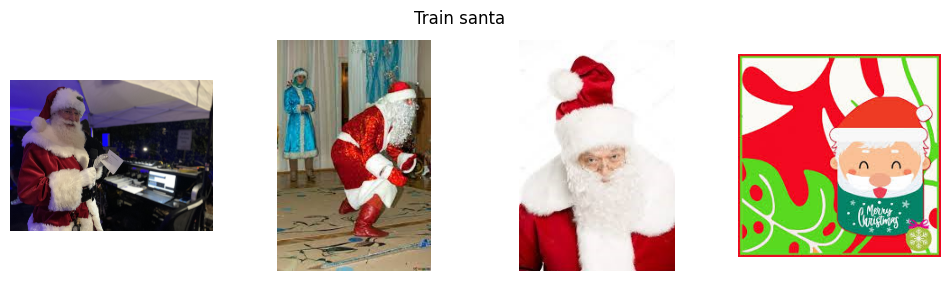

Train normal 이미지 개수: 449


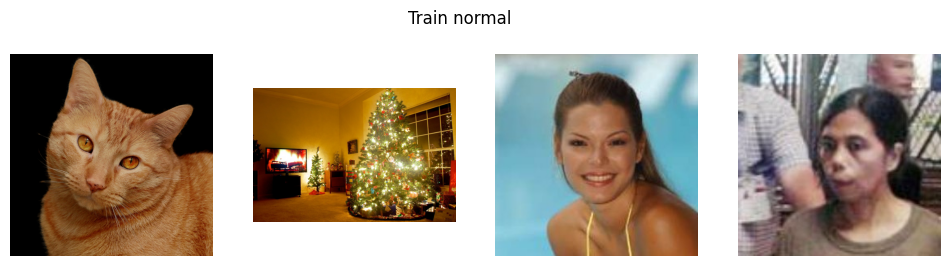

Val santa 이미지 개수: 133


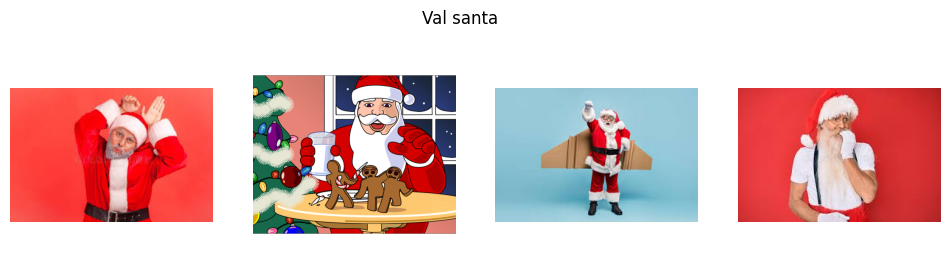

Val normal 이미지 개수: 134


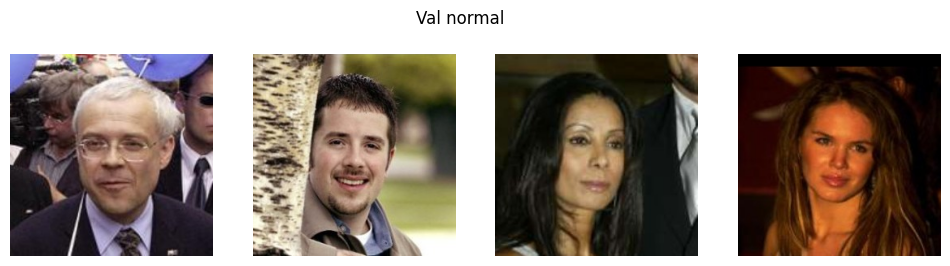

Test santa 이미지 개수: 36


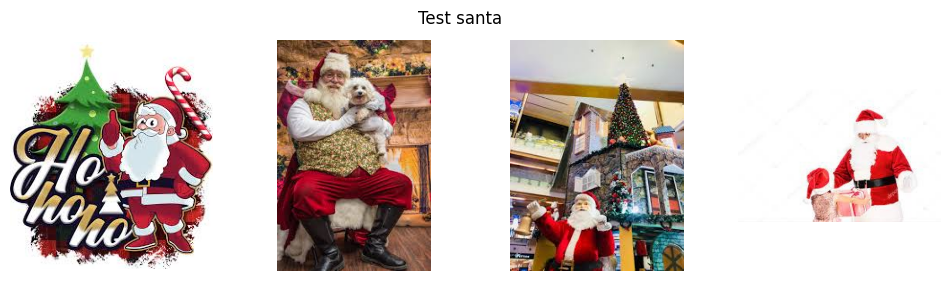

Test normal 이미지 개수: 32


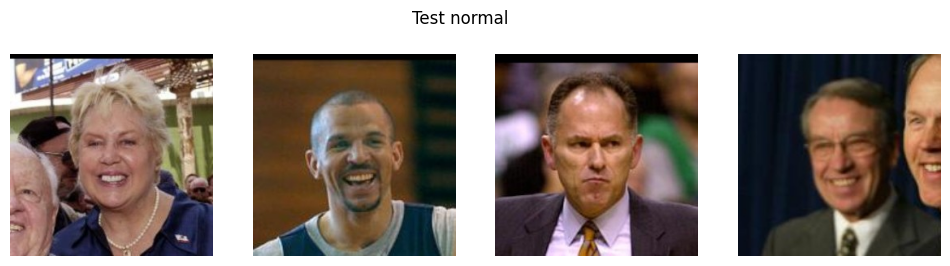

In [3]:
categories = ['Train santa', 'Train normal', 'Val santa', 'Val normal', 'Test santa', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'../실습 파일/4/{category.lower().replace(" ", "/")}/*')
    print(f'{category} 이미지 개수: {len(image_paths)}')
    display_images(image_paths, category)






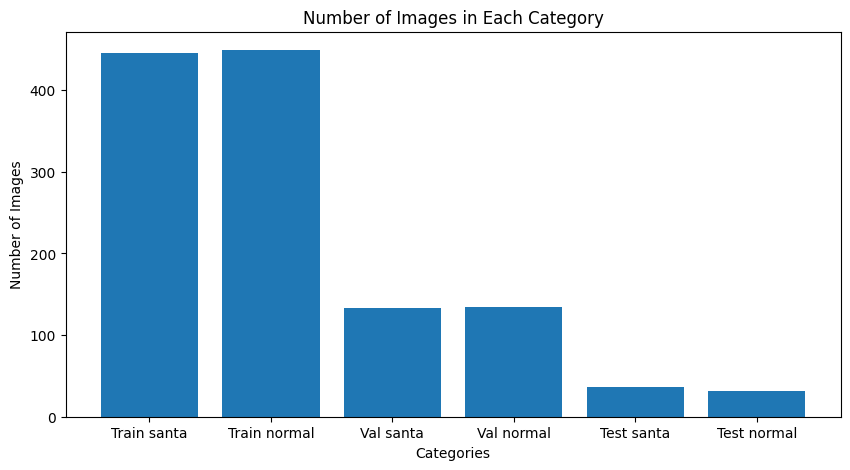

In [4]:
# 바 그래프 생성

plt.figure(figsize=(10, 5))
plt.bar(categories, [len(glob.glob(f'../실습 파일/4/{category.lower().replace(" ", "/")}/*')) for category in categories])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()



In [5]:
# 데이터 augmentation

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [6]:
train_path = '../실습 파일/4/train'
val_path = '../실습 파일/4/val'
test_path = '../실습 파일/4/test'

train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)


In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)






In [8]:
class VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), #기존 논문에서는 1000개의 클래스 분류 문제
            # 시그모이드 활성화 함수는 nn.BCEWithLogitsLoss에 포함
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [16]:

# 사전 학습된 vgg19 모델 불러오기
pretrained_vgg19 = models.vgg19(pretrained=True)

# 새로 정의한 모델 인스턴스 생성성
net = VGG19(num_classes=1000)

# 사전 학습된 모델의 features부분에서 가중치 추출
pretrained_keys = set(pretrained_vgg19.features.state_dict().keys())

result = net.features.load_state_dict(pretrained_vgg19.features.state_dict(), strict=False)

custum_keys = set(net.features.state_dict().keys())

successfully_copied_keys = pretrained_keys.intersection(custum_keys)
missing_keys = pretrained_keys - custum_keys
unexpected_keys = custum_keys - pretrained_keys

print(f"Successfully copied keys: {len(successfully_copied_keys)}, {successfully_copied_keys}")
print(f"Missing keys: {len(missing_keys)}, {result.missing_keys}")
print(f"Unexpected keys: {len(unexpected_keys)}, {result.unexpected_keys}")


c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gfs12\anaconda3\envs\py310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Successfully copied keys: 32, {'19.bias', '10.weight', '34.bias', '16.weight', '25.weight', '0.weight', '5.bias', '2.weight', '12.weight', '7.bias', '2.bias', '28.weight', '23.weight', '5.weight', '21.weight', '28.bias', '12.bias', '10.bias', '19.weight', '34.weight', '25.bias', '30.bias', '7.weight', '0.bias', '14.bias', '32.bias', '32.weight', '21.bias', '23.bias', '30.weight', '16.bias', '14.weight'}
Missing keys: 0, []
Unexpected keys: 0, []


In [17]:
# 모델의 모든 파라미터 고정
for param in net.features.parameters():
    param.requires_grad = False


In [19]:
# classifier 부분의 가중치는 학습을 위해 새로 정의

net.classifier[6] = nn.Linear(4096, 1)

for param in net.classifier.parameters():
    param.requires_grad = True


print(net)


VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [21]:
# 손실함수 정의 -> BCEWithLogitsLoss : 이미 softmax 함수가 포함되어 있음
criterion = nn.BCEWithLogitsLoss()


In [23]:
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    return val_loss, val_accuracy

In [28]:
import torch.optim as optim

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.0001)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.0001)
    else:
        raise ValueError(f"Invalid optimizer: {optimizer_name}")
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            labels = labels.float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        val_loss, val_accuracy = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses:.4f}, Train Accuracy: {train_accuracies:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
    return train_losses, train_accuracies, val_losses, val_accuracies
        
        
        


In [29]:
train_losses_SGD, train_accuracies_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', net, train_loader, val_loader, criterion)



KeyboardInterrupt: 

In [ ]:
train_losses_Adam, train_accuracies_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)


In [ ]:
train_losses_RAdam, train_accuracies_RAdam, val_losses_RAdam, val_accuracies_RAdam = train_model('RAdam', net, train_loader, val_loader, criterion)


In [ ]:
train_losses_AdamW, train_accuracies_AdamW, val_losses_AdamW, val_accuracies_AdamW = train_model('AdamW', net, train_loader, val_loader, criterion)


